# Sistemas de recomendación basados en Grafos con NetworkX



## Agenda

- Introducción al problema
- ¿Qué **ventajas** nos dan los grafos?
- **Construir** el grafo
- Recomendador con **Jaccard**
- Recomendador con **personalized-pagerank**
- Evaluación

## Introducción al problema

Tenemos a nuestra disposición un listado con todas las compras de sus clientes, incluyendo:
- Cliente (comprador)
- Producto que ha comprado
- Fecha de la compra

Nuestra tarea es, para cada cliente, ofrecer un listado de productos que creemos que puedan ser de interés.

## ¿Qué ventajas nos dan los grafos?

- Los grafos nos van a permitir diseñar un modelo que se adapta muy fácilmente a los datos que tenemos disponibles, en el que las relaciones van a tener tanta importancia como las entidades.
- Las recomendaciones se van a convertir en una tarea muy típica en grafos: predicción de aristas.
- Los grafos aportan contexto multirrelacional y transparencia en los recorridos.

## Construir el grafo

### Modelo

- Nodos: **Usuarios** y **Productos**
- Aristas: **compras** (Usuario-Producto, incluyen la fecha de adquisición)

Cargamos el fichero con las compras, `transactions.csv`.

In [1]:
import polars as pl
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

DATA_PATH = Path("data/transactions.csv")

interactions_df = pl.read_csv(DATA_PATH, try_parse_dates=True).sort("timestamp")
interactions_df.head()


user,product,timestamp
str,str,datetime[μs]
"""u19""","""i029""",2024-01-08 03:48:00
"""u05""","""i002""",2024-01-09 05:30:00
"""u17""","""i030""",2024-01-09 18:47:00
"""u08""","""i001""",2024-01-09 23:00:00
"""u19""","""i030""",2024-01-10 12:08:00


In [2]:
# Resumen del dataset

summary = {
    "users": interactions_df["user"].n_unique(),
    "products": interactions_df["product"].n_unique(),
    "interactions": interactions_df.height,
}
summary


{'users': 50, 'products': 60, 'interactions': 637}

## Construir el grafo

### Modelo


Convertimos la tabla en un grafo bipartito donde usuarios y productos viven en particiones separadas.

In [3]:
def build_bipartite_graph(df: pl.DataFrame) -> nx.Graph:
    """Crear el grafo de compras"""
    B = nx.Graph()
    users = df["user"].unique().to_list()
    products = df["product"].unique().to_list()
    B.add_nodes_from(users, bipartite="users")
    B.add_nodes_from(products, bipartite="products")
    for row in df.iter_rows(named=True):
        B.add_edge(row["user"], row["product"], timestamp=row["timestamp"])
    return B


B_full = build_bipartite_graph(interactions_df)
print(f"Nodes: {B_full.number_of_nodes()} | Edges: {B_full.number_of_edges()}")
user_nodes = [n for n, data in B_full.nodes(data=True) if data["bipartite"] == "users"]
product_nodes = [
    n for n, data in B_full.nodes(data=True) if data["bipartite"] == "products"
]
print(f"User nodes: {len(user_nodes)} | Product nodes: {len(product_nodes)}")


Nodes: 110 | Edges: 637
User nodes: 50 | Product nodes: 60


In [11]:
centrality = nx.betweenness_centrality(B_full)
import polars as pl

pl.DataFrame({"id": centrality.keys(), "betweenness": centrality.values()}).sort(
    "betweenness", descending=True
).head(10)


id,betweenness
str,f64
"""i001""",0.108027
"""i021""",0.072126
"""i002""",0.06689
"""i049""",0.037375
"""i050""",0.029911
"""u21""",0.028926
"""i030""",0.02814
"""u37""",0.027625
"""i031""",0.026937


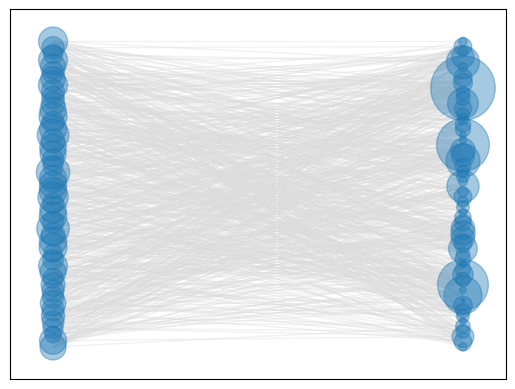

In [7]:

node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    B_full,
    pos=nx.layout.bipartite_layout(B_full, user_nodes),
    with_labels=False,
    # node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

Confirmamos que el tipo de los nodos se ha cargado correctamente.

In [4]:
for node in user_nodes[:3]:
    print(node, B_full.nodes[node])
for node in product_nodes[:3]:
    print(node, B_full.nodes[node])


u18 {'bipartite': 'users'}
u09 {'bipartite': 'users'}
u38 {'bipartite': 'users'}
i047 {'bipartite': 'products'}
i005 {'bipartite': 'products'}
i025 {'bipartite': 'products'}


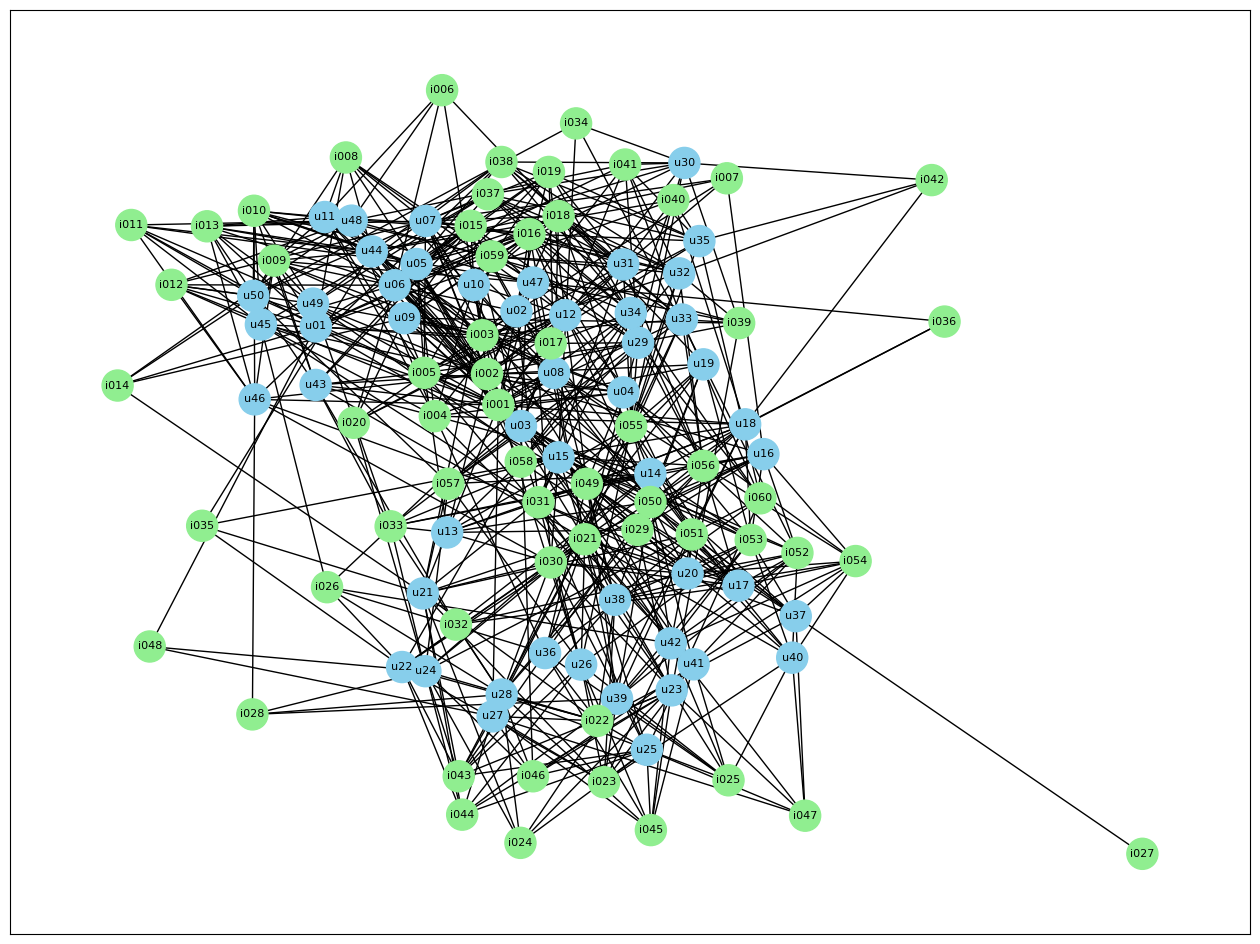

In [5]:
plt.figure(figsize=(16, 12))
nx.draw_networkx(
    B_full,
    pos=nx.layout.spring_layout(
        B_full,
    ),
    with_labels=True,
    node_size=500,
    font_size=8,
    node_color=["skyblue" if n in user_nodes else "lightgreen" for n in B_full.nodes()],
)

Visualizamos a continuación un egografo centrado en un usuario concreto.

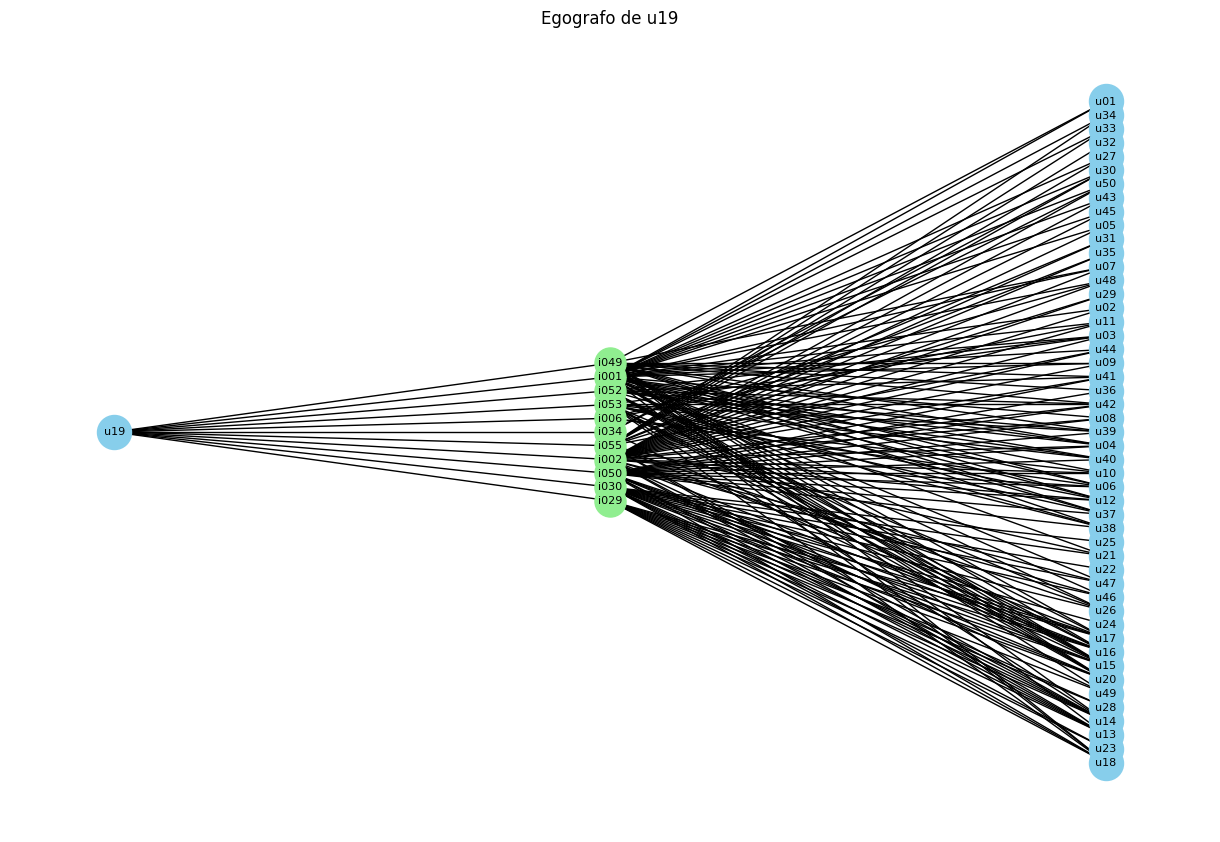

In [6]:
def plot_ego(B: nx.Graph, user: str) -> None:
    """Generar una visualización del egografo centrado en un usuario"""
    if user not in B:
        raise ValueError(f"User {user} not present in the graph")

    ego: nx.Graph = nx.ego_graph(B, user, radius=2)
    # pos = nx.spring_layout(ego, seed=7)
    # pos = nx.bipartite_layout(ego, nodes=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "users"])
    pos = nx.bfs_layout(ego, start=user)
    plt.figure(figsize=(12, 8))
    nx.draw(ego, pos, with_labels=True, node_size=400, font_size=8)
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "users"],
        node_size=600,
        node_color="skyblue",
    )
    nx.draw_networkx_nodes(
        ego,
        pos,
        nodelist=[n for n in ego.nodes if ego.nodes[n]["bipartite"] == "products"],
        node_size=500,
        node_color="lightgreen",
    )
    plt.title(f"Egografo de {user}")
    plt.show()


example_user = interactions_df["user"][0]
plot_ego(B_full, example_user)


## Recomendador con Jaccard

Implementamos un sistema de recomendación que utiliza el coeficiente de Jaccard calculado por networkx para ponderar los productos más recomendables.

In [7]:
from collections import defaultdict


def recommend_jaccard_graph(
    B: nx.Graph,
    user: str,
) -> pl.DataFrame:
    """Usar jaccard_coefficient para puntuar productos para un usuario."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    ego: nx.Graph = nx.ego_graph(B, user, radius=2, center=False)

    neighbors = [
        n for n, data in ego.nodes(data=True) if data.get("bipartite") == "users"
    ]
    seen = set(B.neighbors(user))
    ebunch = list((user, neighbor) for neighbor in neighbors)
    jaccard = dict([((u, v), p) for u, v, p in nx.jaccard_coefficient(B, ebunch)])
    scored_products = defaultdict(float)

    for neighbor in neighbors:
        for product in B.neighbors(neighbor):
            if product not in seen:
                scored_products[product] += jaccard.get((user, neighbor), 0)

    return pl.DataFrame(
        {
            "product": list(scored_products.keys()),
            "score": list(scored_products.values()),
        }
    )


demo_user = interactions_df["user"][0]
cf_demo = recommend_jaccard_graph(B_full, demo_user)

print(f"Demo user: {demo_user}")
print("Recomendaciones Jaccard:", cf_demo.sort("score", descending=True).head(5))


Demo user: u19
Recomendaciones Jaccard: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i021    ┆ 4.10662  │
│ i031    ┆ 3.594668 │
│ i051    ┆ 3.492953 │
│ i003    ┆ 2.819335 │
│ i054    ┆ 2.710246 │
└─────────┴──────────┘


## Recomendador con Adamic-Adar

Usamos la medida Adamic-Adar para ponderar usuarios similares según sus compras compartidas.


In [8]:
from collections import defaultdict


def recommend_adamic_adar_graph(
    B: nx.Graph,
    user: str,
) -> pl.DataFrame:
    """Usar adamic_adar_index para puntuar productos para un usuario."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    ego = nx.ego_graph(B, user, radius=2, center=False)
    neighbors = [
        n for n, data in ego.nodes(data=True) if data.get("bipartite") == "users"
    ]
    if not neighbors:
        return pl.DataFrame({"product": [], "score": []})
    seen = set(B.neighbors(user))
    ebunch = [(user, neighbor) for neighbor in neighbors]
    adamic_adar = {(u, v): score for u, v, score in nx.adamic_adar_index(B, ebunch)}
    scored_products = defaultdict(float)
    for neighbor in neighbors:
        weight = adamic_adar.get((user, neighbor), 0.0)
        if weight == 0.0:
            continue
        for product in B.neighbors(neighbor):
            if product not in seen:
                scored_products[product] += weight
    return pl.DataFrame(
        {
            "product": list(scored_products.keys()),
            "score": list(scored_products.values()),
        }
    )


aa_demo = recommend_adamic_adar_graph(B_full, demo_user)

print("Recomendaciones Adamic-Adar:", aa_demo.sort("score", descending=True).head(5))


Recomendaciones Adamic-Adar: shape: (5, 2)
┌─────────┬───────────┐
│ product ┆ score     │
│ ---     ┆ ---       │
│ str     ┆ f64       │
╞═════════╪═══════════╡
│ i021    ┆ 27.775641 │
│ i031    ┆ 23.516208 │
│ i051    ┆ 22.95682  │
│ i003    ┆ 19.717151 │
│ i054    ┆ 17.123962 │
└─────────┴───────────┘


## Recomendador con Personalized Pagerank

In [9]:
def recommend_ppr(
    B: nx.Graph, user: str, *, alpha: float = 0.85, max_iter: int = 100
) -> pl.DataFrame:
    """Usar Personalized PageRank para puntuar productos para un usuario."""
    if user not in B:
        return pl.DataFrame({"product": [], "score": []})
    personalization = {user: 1.0}
    scores = nx.pagerank(
        B, alpha=alpha, personalization=personalization, max_iter=max_iter
    )
    seen = set(B.neighbors(user))

    scored_products = {
        node: score
        for node, score in scores.items()
        if B.nodes[node].get("bipartite") == "products" and node not in seen
    }

    return pl.DataFrame(
        {
            "product": list(scored_products.keys()),
            "score": list(scored_products.values()),
        }
    )


demo_user = interactions_df["user"][0]
ppr_demo = recommend_ppr(B_full, demo_user)
print(f"Demo user: {demo_user}")
print("Recomendaciones PPR:", ppr_demo.sort("score", descending=True).head(5))


Demo user: u19
Recomendaciones PPR: shape: (5, 2)
┌─────────┬──────────┐
│ product ┆ score    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ i021    ┆ 0.012619 │
│ i031    ┆ 0.00888  │
│ i003    ┆ 0.008589 │
│ i051    ┆ 0.008019 │
│ i016    ┆ 0.007341 │
└─────────┴──────────┘


## Evaluación

Usamos la última compra para calcular la calidad de las recomendaciones.

In [10]:
def train_test_split_last_product_per_user(
    df: pl.DataFrame,
) -> tuple[pl.DataFrame, pl.DataFrame]:
    """Separar la última compra según el timestamp."""
    df_sorted = df.sort(["user", "timestamp"]).with_row_index("row_id")
    test = df_sorted.group_by("user", maintain_order=True).tail(1)
    train = df_sorted.filter(~pl.col("row_id").is_in(test["row_id"].implode()))
    return train.drop("row_id"), test.drop("row_id")


def precision_recall_at_k(
    recs: list[str], truth: list[str], k: int
) -> tuple[float, float]:
    """Devolver Precision@k y Recall@k para un listado."""
    recs_k = recs[:k]
    hits = len(set(recs_k) & set(truth))
    precision = hits / max(1, len(recs_k))
    recall = hits / max(1, len(truth))
    return precision, recall


def to_user_products(df: pl.DataFrame) -> dict[str, set[str]]:
    """Devuelve un dict con el set de productos que ha comprado cada usuario."""
    user_products: dict[str, set[str]] = defaultdict(set)
    for row in df.iter_rows(named=True):
        user_products[row["user"]].add(row["product"])
    return user_products


def evaluate_jaccard_graph(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_products = to_user_products(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_products in test_user_products.items():
        if user not in train_graph:
            continue
        scores_df = recommend_jaccard_graph(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df.sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_products), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


def evaluate_adamic_adar_graph(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_products = to_user_products(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_products in test_user_products.items():
        if user not in train_graph:
            continue
        scores_df = recommend_adamic_adar_graph(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df.sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_products), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


def evaluate_ppr(
    train_df: pl.DataFrame, test_df: pl.DataFrame, *, topn: int
) -> tuple[float, float, int]:
    train_graph = build_bipartite_graph(train_df)
    test_user_products = to_user_products(test_df)
    metrics: list[tuple[float, float]] = []
    for user, truth_products in test_user_products.items():
        if user not in train_graph:
            continue
        scores_df = recommend_ppr(train_graph, user)
        if scores_df.height == 0:
            continue
        recs = (
            scores_df.sort("score", descending=True)
            .head(topn)
            .get_column("product")
            .to_list()
        )
        precision, recall = precision_recall_at_k(recs, list(truth_products), topn)
        metrics.append((precision, recall))
    if not metrics:
        return 0.0, 0.0, 0
    precision_avg = sum(p for p, _ in metrics) / len(metrics)
    recall_avg = sum(r for _, r in metrics) / len(metrics)
    return precision_avg, recall_avg, len(metrics)


- Precision: Of the top k items you predicted/recommended, how many were actually relevant?
- Recall: Of all the relevant items that exist for this user/query, how many did you include in the top k?

In [11]:
train_df, test_df = train_test_split_last_product_per_user(interactions_df)
top_k = 5
cf_prec, cf_rec, cf_users = evaluate_jaccard_graph(train_df, test_df, topn=top_k)
aa_prec, aa_rec, aa_users = evaluate_adamic_adar_graph(train_df, test_df, topn=top_k)
ppr_prec, ppr_rec, ppr_users = evaluate_ppr(train_df, test_df, topn=top_k)
print(
    f"Graph Jaccard \n\tPrecision@{top_k}: {cf_prec:.3f} \n\tRecall@{top_k}: {cf_rec:.3f} over {cf_users} users"
)
print(
    f"Adamic-Adar \n\tPrecision@{top_k}: {aa_prec:.3f} \n\tRecall@{top_k}: {aa_rec:.3f} over {aa_users} users"
)
print(
    f"PPR \n\tPrecision@{top_k}: {ppr_prec:.3f} \n\tRecall@{top_k}: {ppr_rec:.3f} over {ppr_users} users"
)


Graph Jaccard 
	Precision@5: 0.148 
	Recall@5: 0.740 over 50 users
Adamic-Adar 
	Precision@5: 0.144 
	Recall@5: 0.720 over 50 users
PPR 
	Precision@5: 0.124 
	Recall@5: 0.620 over 50 users


## Next steps

- Usar información temporal para limitar las compras que se tienen en cuenta.
- ¿Cómo gestionar productos que se compran repetidas veces?
- Usar un algoritmo tipo graph2vec para crear embeddings, y que estos formen parte de un modelo ML más avanzado.